Attempting to load data from: C:/Users/rajar/Downloads/credit_risk_dataset.csv
Data shape: (32549, 12)
Columns: ['person_age', 'person_income', 'person_home_ownership', 'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt', 'loan_int_rate', 'loan_status', 'loan_percent_income', 'cb_person_default_on_file', 'cb_person_cred_hist_length']

Target Column Detected: loan_status
Numeric features: 7
Categorical features: 4

>>> Tuning Hyperparameters...
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best ROC-AUC: 0.9441

>>> Evaluating on Test Set...
Accuracy: 0.9361
ROC-AUC: 0.9474

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.99      0.96      5090
           1       0.97      0.73      0.83      1420

    accuracy                           0.94      6510
   macro avg       0.95      0.86      0.90      6510
weighted avg       0.94      0.94      0.93      6510



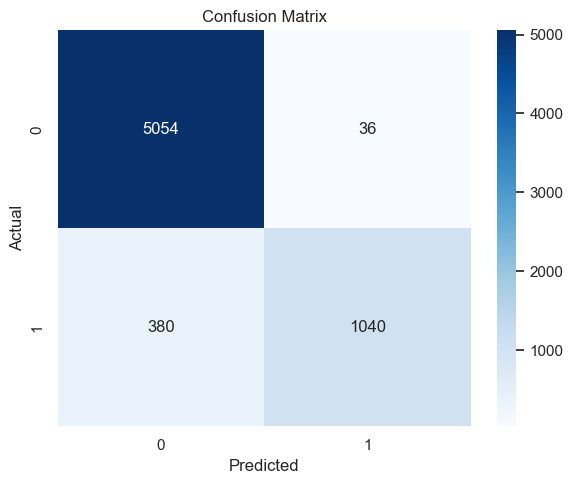

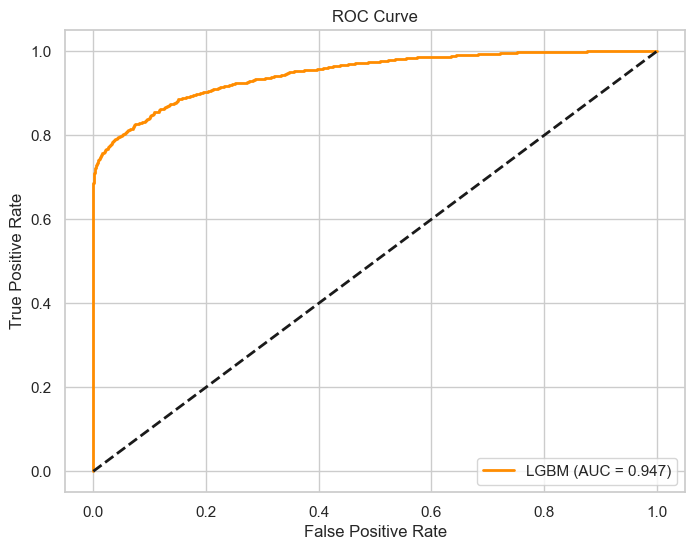


>>> Generating SHAP Explanations...


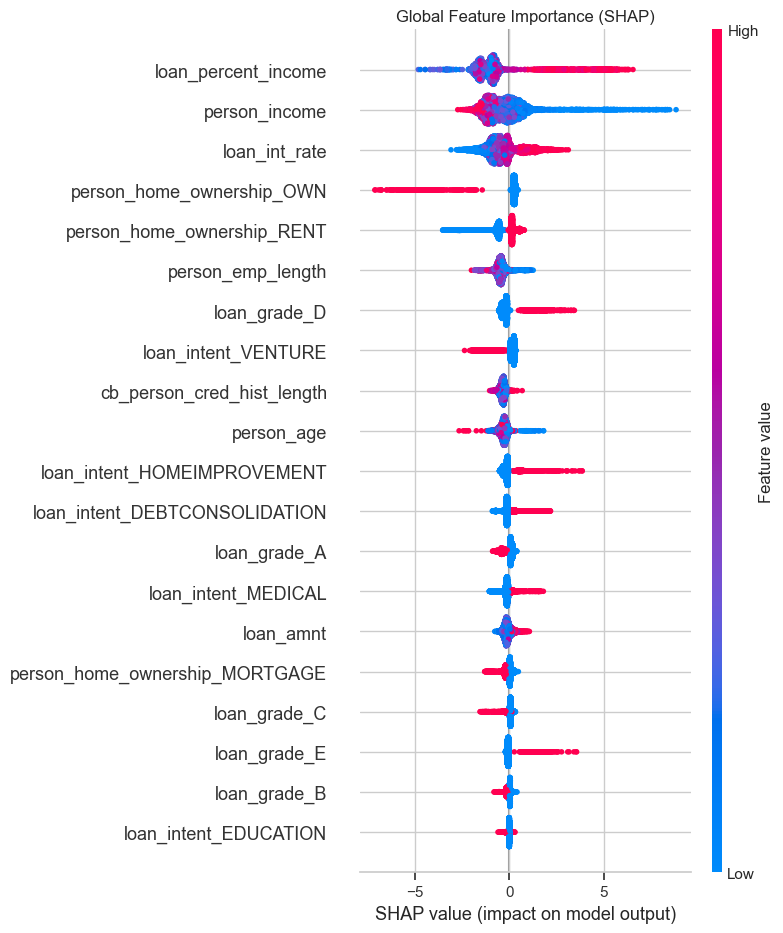


>>> Generating Local Explanations for Specific Profiles...

--- Analyzing: High Risk Customer (Index: 1) ---
Predicted Probability of Default: 0.9986


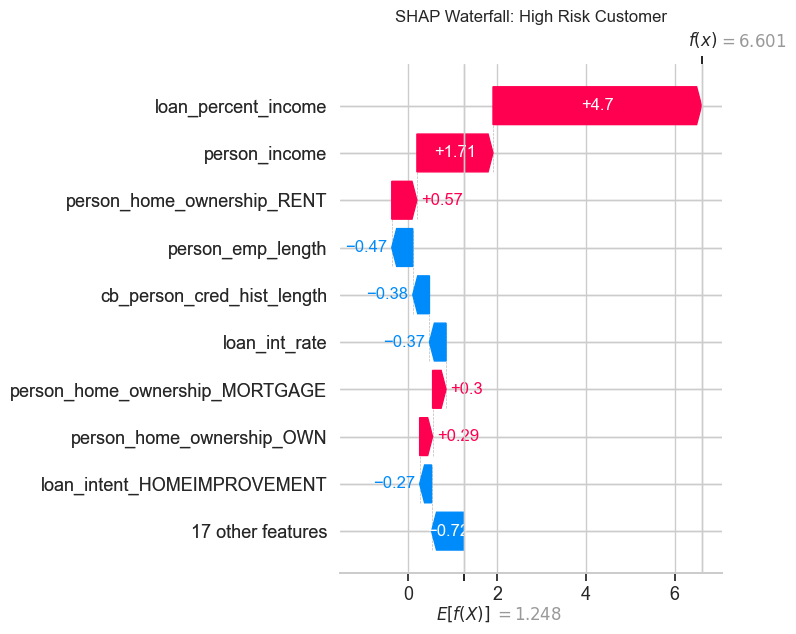

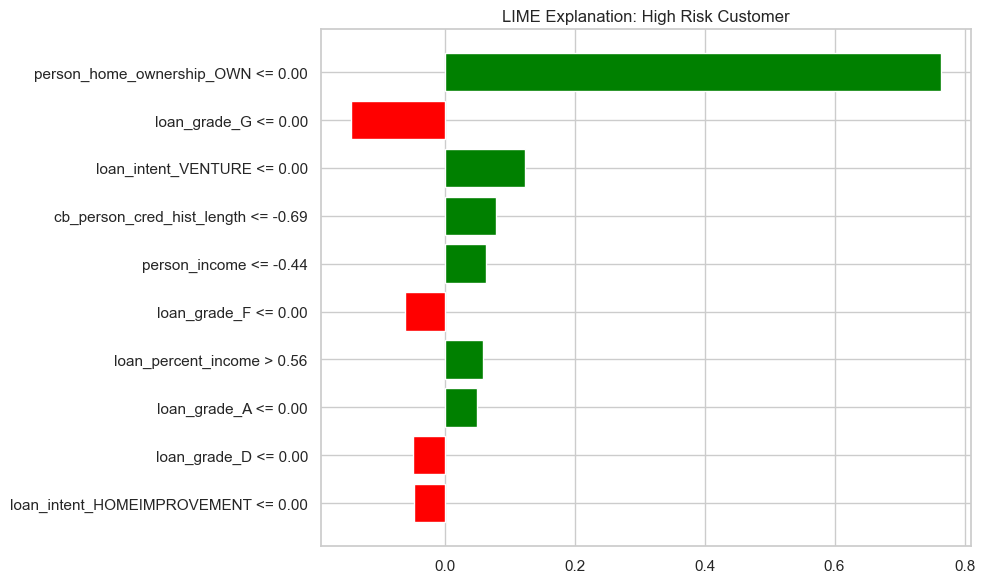


--- Analyzing: Low Risk Customer (Index: 2) ---
Predicted Probability of Default: 0.0454


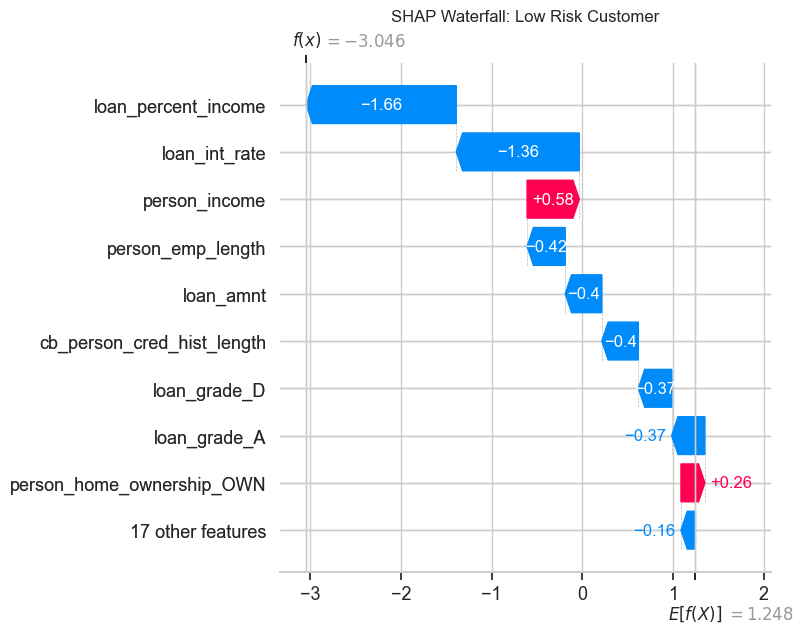

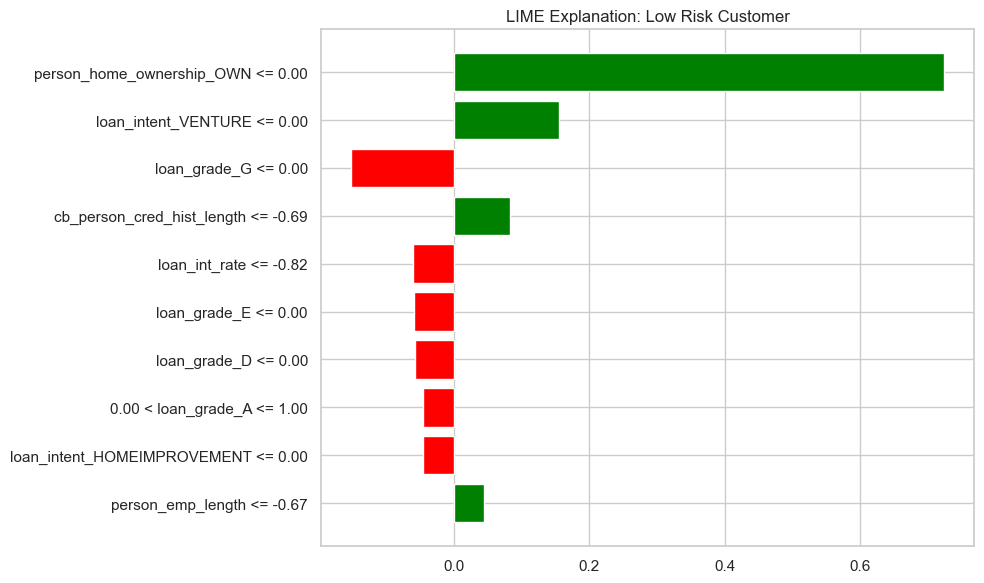


--- Analyzing: Borderline Customer (Index: 65) ---
Predicted Probability of Default: 0.4613


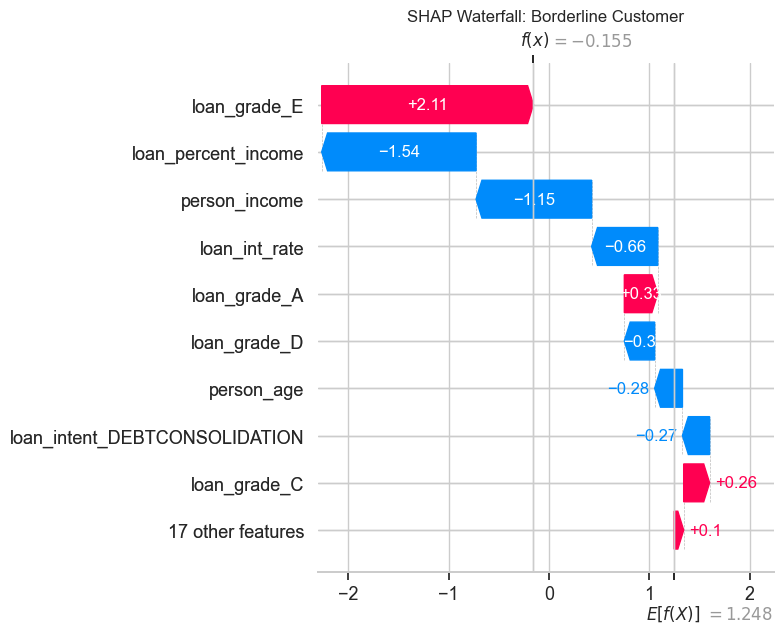

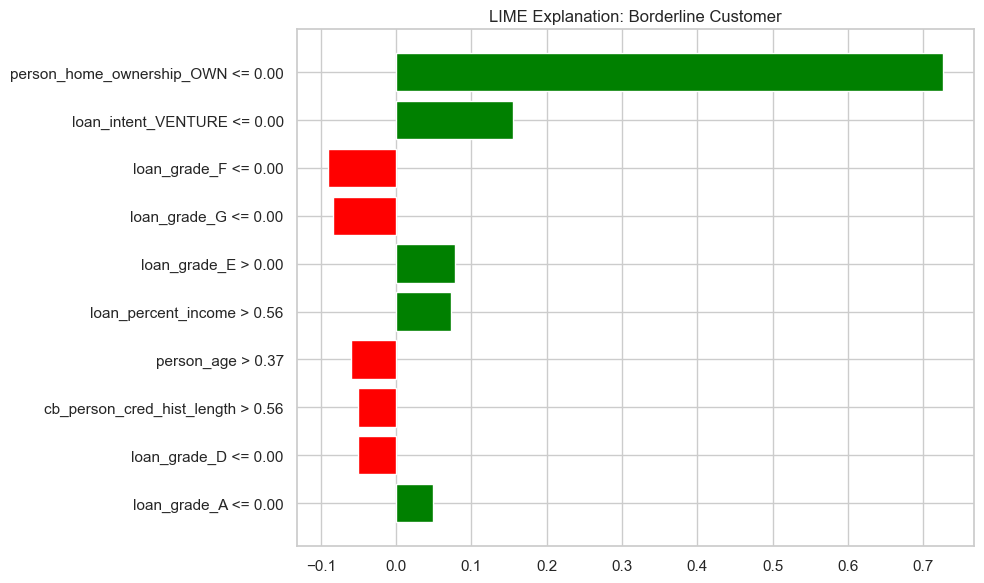


Processing Complete.


In [2]:
# ================================================================
# Interpretable Machine Learning for High-Dimensional
# Credit Risk Prediction using SHAP and LIME
# ================================================================

import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Sklearn & Imbalanced-Learn
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score, roc_curve, precision_recall_curve, f1_score
)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Model & Explainability
from lightgbm import LGBMClassifier
import shap
from lime.lime_tabular import LimeTabularExplainer

# Configuration
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# ================================================================
# 1. Data Loading 
# ================================================================
FILE_PATH = "C:/Users/rajar/Downloads/credit_risk_dataset.csv"

def load_data(path):
    print(f"Attempting to load data from: {path}")
    
    if not os.path.exists(path):
        # Check if maybe the user provided just the filename and it's in the current folder
        if os.path.exists(os.path.basename(path)):
            path = os.path.basename(path)
            print(f"Found file in current directory: {path}")
        else:
            print("\n" + "="*50)
            print("ERROR: FILE NOT FOUND!")
            print(f"Python cannot find the file at: {path}")
            print("Tip: Right-click your file -> Copy as Path -> Paste it into FILE_PATH above.")
            print("="*50 + "\n")
            sys.exit(1) # Stop execution if file is missing

    df = pd.read_csv(path)
    return df

df = load_data(FILE_PATH)
print("Data shape:", df.shape)
print("Columns:", df.columns.tolist())

# ================================================================
# 2. Define Target and Features
# ================================================================
# Logic to auto-detect target if standard names are used, otherwise default to last column
possible_targets = ["loan_status", "cb_person_default_on_file", "default"]
TARGET_COL = None

for t in possible_targets:
    if t in df.columns:
        TARGET_COL = t
        break

if TARGET_COL is None:
    TARGET_COL = df.columns[-1] # Fallback to last column

print(f"\nTarget Column Detected: {TARGET_COL}")

y = df[TARGET_COL]
X = df.drop(columns=[TARGET_COL])

# Handle Target Encoding if it's text (e.g., Y/N)
if y.dtype == 'object' or isinstance(y.iloc[0], str):
    le = LabelEncoder()
    y = le.fit_transform(y)
    print(f"Target encoded. Classes: {le.classes_}")

# Feature Selection
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = X.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

print(f"Numeric features: {len(numeric_cols)}")
print(f"Categorical features: {len(categorical_cols)}")

# ================================================================
# 3. Train-Test Split
# ================================================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ================================================================
# 4. Preprocessing & Pipeline Construction
# ================================================================
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]
)

# LightGBM Pipeline with SMOTE
pipeline = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("model", LGBMClassifier(n_estimators=200, random_state=42, verbose=-1))
])

# ================================================================
# 5. Hyperparameter Tuning (Simplified for speed)
# ================================================================
print("\n>>> Tuning Hyperparameters...")
param_distributions = {
    "model__num_leaves": [31, 50],
    "model__learning_rate": [0.05, 0.1],
    "model__max_depth": [5, 10, -1]
}

search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=5, 
    cv=3,
    scoring="roc_auc",
    n_jobs=-1,
    random_state=42,
    verbose=1
)

search.fit(X_train, y_train)
best_model = search.best_estimator_
print(f"Best ROC-AUC: {search.best_score_:.4f}")

# ================================================================
# 6. Evaluation
# ================================================================
print("\n>>> Evaluating on Test Set...")
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

# Metrics
auc_score = roc_auc_score(y_test, y_proba)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC-AUC: {auc_score:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.tight_layout()
plt.show()

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"LGBM (AUC = {auc_score:.3f})", color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

# ================================================================
# 7. SHAP Global Interpretation
# ================================================================
print("\n>>> Generating SHAP Explanations...")

# Access internal steps
model_step = best_model.named_steps["model"]
preprocessor_step = best_model.named_steps["preprocessor"]

# Transform test data for SHAP
X_test_trans = preprocessor_step.transform(X_test)

# Get feature names
ohe_feature_names = []
if categorical_cols:
    ohe = preprocessor_step.named_transformers_["cat"].named_steps["onehot"]
    ohe_feature_names = ohe.get_feature_names_out(categorical_cols)
feature_names = np.concatenate([numeric_cols, ohe_feature_names])

# Compute SHAP values
explainer = shap.TreeExplainer(model_step)
# Note: For some LGBM versions, shap_values is a list [class0, class1]
shap_values = explainer.shap_values(X_test_trans)

if isinstance(shap_values, list):
    # Take positive class
    vals = shap_values[1]
else:
    vals = shap_values

# Global Summary Plot
plt.figure()
shap.summary_plot(vals, X_test_trans, feature_names=feature_names, show=False)
plt.title("Global Feature Importance (SHAP)")
plt.tight_layout()
plt.show()

# ================================================================
# 8. Local Explanations (LIME & SHAP Waterfall)
# ================================================================
print("\n>>> Generating Local Explanations for Specific Profiles...")

# Identify indices for High Risk (>85%), Low Risk (<15%), and Borderline (~50%)
probs = y_proba
high_risk_idx = np.where(probs > 0.85)[0]
low_risk_idx = np.where(probs < 0.15)[0]
border_risk_idx = np.where(np.abs(probs - 0.5) < 0.1)[0]

# fallback if no exact matches found
if len(high_risk_idx) == 0: high_risk_idx = [np.argmax(probs)]
if len(low_risk_idx) == 0: low_risk_idx = [np.argmin(probs)]
if len(border_risk_idx) == 0: border_risk_idx = [np.argmin(np.abs(probs - 0.5))]

indices = {
    "High Risk Customer": high_risk_idx[0],
    "Low Risk Customer": low_risk_idx[0],
    "Borderline Customer": border_risk_idx[0]
}

# Helper for LIME
if hasattr(X_train, "toarray"):
    X_train_dense = preprocessor_step.transform(X_train).toarray()
    X_test_dense = X_test_trans.toarray()
else:
    X_train_dense = preprocessor_step.transform(X_train)
    X_test_dense = X_test_trans

# Initialize LIME Explainer
lime_explainer = LimeTabularExplainer(
    training_data=X_train_dense,
    feature_names=feature_names,
    class_names=['No Default', 'Default'],
    mode='classification'
)

def proba_fn(x):
    return model_step.predict_proba(x)

for name, idx in indices.items():
    print(f"\n--- Analyzing: {name} (Index: {idx}) ---")
    print(f"Predicted Probability of Default: {probs[idx]:.4f}")
    
    # 1. SHAP Waterfall
    # Note: legacy waterfall is safer for simple matrix inputs
    plt.figure()
    shap.plots._waterfall.waterfall_legacy(
        explainer.expected_value[1] if isinstance(explainer.expected_value, (list, np.ndarray)) else explainer.expected_value,
        vals[idx],
        feature_names=feature_names,
        max_display=10,
        show=False
    )
    plt.title(f"SHAP Waterfall: {name}")
    plt.tight_layout()
    plt.show()
    
    # 2. LIME
    exp = lime_explainer.explain_instance(
        X_test_dense[idx],
        proba_fn,
        num_features=10
    )
    # LIME plot
    fig = exp.as_pyplot_figure()
    plt.title(f"LIME Explanation: {name}")
    plt.tight_layout()
    plt.show()

print("\nProcessing Complete.")